# Miscellaneous visualizations with captum.optim

This notebook demonstrates the use of the captum.optim submodule for visualization tasks such as neuron groups and caricatures.

In [ ]:
%load_ext autoreload
%autoreload 2

import torch
import torchvision
from captum.optim._models.inception_v1 import googlenet

import captum.optim as optimviz

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = googlenet(pretrained=True).to(device).eval()

We'll load some images for testing, and setup some helper functions.

In [ ]:
import numpy as np
from PIL import Image

!wget https://storage.googleapis.com/lucid-static/building-blocks/examples/dog_cat.png
image = Image.open("dog_cat.png").convert('RGB')
catdog_image = torch.as_tensor(np.array(image)).permute(2, 0, 1).unsqueeze(0) / 255

!wget https://storage.googleapis.com/lucid-static/building-blocks/examples/flowers.png
image = Image.open("flowers.png").convert('RGB')
flower_image = torch.as_tensor(np.array(image)).permute(2, 0, 1).unsqueeze(0) / 255

In [5]:
import numpy as np
import matplotlib.pyplot as plt


def show(x: np.ndarray, scale: float = 255.0) -> None:
    assert len(x.shape) == 3
    x = x.permute(1,2,0).numpy() if torch.is_tensor(x) else x
    if x.shape[2] == 1:
        x = np.concatenate([x, x, x], 2)
    x = x * scale
    plt.imshow(x.astype(np.uint8))
    plt.axis("off")
    plt.show()

## Neuron Groups

The code below let's us visualize Neuron Groups, so that we can see how detectors view different spatial regions of an input.

In [10]:
# Helper functions

from captum.optim._utils.models import ActivationCatcher


def vis_direction(model, target, vec=None) -> None:
    image = optimviz.images.NaturalImage((80,80)).to(device)
    loss_fn = optimviz.loss.Direction(target, vec)
    transforms = torch.nn.Sequential(
        torch.nn.ReflectionPad2d(16),
        optimviz.transform.RandomSpatialJitter(16),
        optimviz.transform.RandomScale(scale=(1, 0.975, 1.025, 0.95, 1.05)),
        torchvision.transforms.RandomRotation(degrees=(-5,5)),
        optimviz.transform.RandomSpatialJitter(8),
        optimviz.transform.CenterCrop(16),
    )  
    obj = optimviz.InputOptimization(model, image, transforms, [target], loss_fn)
    history = obj.optimize(optimviz.objectives.n_steps(128, False))
    return image()._t


def neuron_groups(model_input, model, target, n_groups=6):
    activations = optimviz.models.collect_activations(model, [target], model_input)[target].detach()
  
    reducer = optimviz.reducer.ChannelReducer(n_groups, "NMF")
    spatial_factors = reducer.fit_transform(activations)[0]
    channel_factors = reducer.components

    s_max, _ = spatial_factors.max(1)
    x_peak = torch.argmax(s_max, 1)
    ns_sorted = torch.argsort(x_peak)

    spatial_factors = spatial_factors[ns_sorted]
    channel_factors = channel_factors[ns_sorted]

    group_vecs = [spatial_factors[i, ..., None]*channel_factors[i] for i in range(n_groups)]
    
    x_tensors = [factor.unsqueeze(0) / torch.quantile(spatial_factors,99/100) for factor in spatial_factors]

    show(model_input[0])
    show(torch.cat(x_tensors[:3], 0))
    show(torch.cat(x_tensors[3:], 0))

    A = []
    for i in range(n_groups):
        x_out = vis_direction(model, target, channel_factors[i])
        A.append(x_out.detach().squeeze(0))

    grid_img = torchvision.utils.make_grid(torch.stack(A), nrow=n_groups)
    show(grid_img)

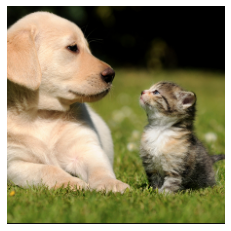

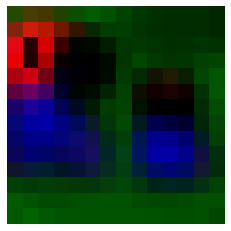

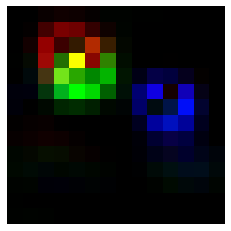

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


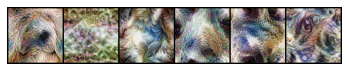

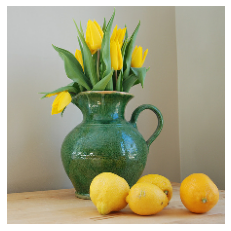

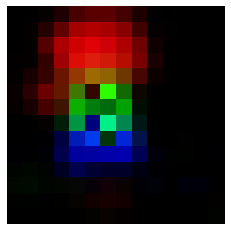

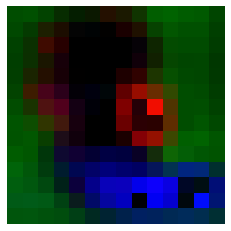

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


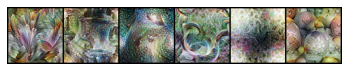

In [11]:
neuron_groups(catdog_image, model, model.mixed4d, 6)
neuron_groups(flower_image, model, model.mixed4d, 6)

## Feature Inversion Caricatures


This an image visualization technique based on research by [Mahendran and Vedaldi](https://arxiv.org/pdf/1412.0035.pdf). 

Compared to their work, we use a dot product object and transform robustness.

In [12]:
# Helper classes & functions

class StackImage(optimviz.images.ImageParameterization):
    def __init__(
        self,
        init: torch.Tensor,
        parameterization=None,
    ) -> None:
        super().__init__()
        assert init.dim() == 4
        self.image = torch.nn.Parameter(init)
        self.parameterization = parameterization

    def forward(self) -> torch.Tensor:
        image = self.parameterization()
        return torch.cat([image, self.image], 0).refine_names("B", "C", "H", "W")


class DotCompare(optimviz.loss.Loss):
    def __init__(
        self,
        target: torch.nn.Module = None,
        cossim_pow: float = 0
    ) -> None:
        super(optimviz.loss.Loss, self).__init__()
        self.target = target
        self.cossim_pow = cossim_pow

    def __call__(self, targets_to_values) -> torch.Tensor:
        activations = targets_to_values[self.target]
        assert activations.size(0) == 2
        dot = torch.sum(activations[0] * activations[1])
        mag = torch.sqrt(torch.sum(activations[0]**2))
        cossim = dot / (1e-6 + mag)
        return dot * cossim ** self.cossim_pow


def vis_feature_inversion(model, target, init, init2, cossim_pow=0) -> None:
    image = optimviz.images.NaturalImage((224,224), batch=2, init=init).to(device)
    init2 = image.decorrelate(init2.refine_names("B", "C", "H", "W"), inverse=True)
    image.parameterization = StackImage(init2, parameterization=image.parameterization)
    loss_fn = DotCompare(target, cossim_pow=cossim_pow)
    transforms = torch.nn.Sequential(
        torch.nn.ReflectionPad2d(16),
        optimviz.transform.RandomSpatialJitter(16),
        optimviz.transform.RandomScale(scale=(1, 0.975, 1.025, 0.95, 1.05)),
        torchvision.transforms.RandomRotation(degrees=(-5,5)),
        optimviz.transform.RandomSpatialJitter(8),
        optimviz.transform.CenterCrop(16),
    )  
    obj = optimviz.InputOptimization(model, image, transforms, [target], loss_fn)
    history = obj.optimize(optimviz.objectives.n_steps(128))
    show(image()._t[0].detach())

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


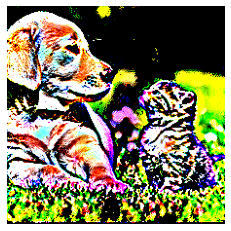

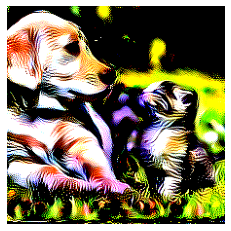

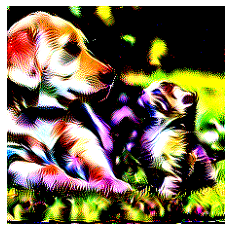

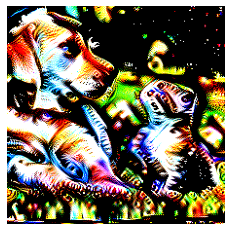

In [13]:
size = (224,224)
init2 = torch.nn.functional.interpolate(catdog_image, size=size)
init = torch.zeros(1, 3, size[0], size[1])

vis_feature_inversion(model, model.conv1, init=init, init2=init2, cossim_pow=0.5)
vis_feature_inversion(model, model.conv2, init=init, init2=init2)
vis_feature_inversion(model, model.conv3, init=init, init2=init2)
vis_feature_inversion(model, model.mixed3a, init=init, init2=init2)